In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./(obs_per_day * linspace))
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5


def true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda - true_rho * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], state_ls[:, 1], np.log(states[:, 2])


Tt, It, true_x = true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day)



def MaternKernel(d, phi_1, phi_2, nu=2.5):
    """
    construct a kernel given time points and hyper parameters
    """
    if nu == 2.5:  
        a = np.square(phi_1) * (
                1. + np.sqrt(5) * d / phi_2 + 5. * np.square(d) / (3. * np.square(phi_2))) * np.exp(
            -np.sqrt(5) * d / phi_2)
        return a
    elif nu == 1.5:
        a = np.square(phi_1) * (1. + np.sqrt(3) * d / phi_2) * np.exp(-np.sqrt(3) * d / phi_2)       
        return a
    else:
        raise ValueError

def GPinterp(x, y, phi_1, phi_2, inv_cov, days=100, obs_per_day=1):
    x_obs = np.arange(0, days, 1 / obs_per_day)
    return y.T.dot(inv_cov).dot(MaternKernel(np.abs(x_obs - x), phi_1, phi_2, nu=2.5))

def recover_data(a1, a2, Tt, state0, linspace=100, days=100, obs_per_day=1, discretization=1, mode = 'Gaussian', hyper=None):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    x_initial = np.linspace(0, 1000, days)
    x_interp = np.linspace(0, 1000, days * linspace)
    Tt_interp = np.interp(x_interp, x_initial, Tt)
    if mode == 'Linear': 
        a1_interp = np.interp(x_interp, x_initial, a1)
        a2_interp = np.interp(x_interp, x_initial, a2)
        Tt_interp = np.interp(x_interp, x_initial, Tt)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        n_points = days * discretization * obs_per_day
        d_matrix = np.zeros((n_points, n_points))
        for i in range(n_points):
            for j in range(n_points):
                if i > j:
                    d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
                else:
                    d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
        a1_interp = np.zeros(10000)
        a2_interp = np.zeros(10000)
        a1_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[0][0], hyper[0][1]))
        a2_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[1][0], hyper[1][1]))
        for i in range(10000):
            a1_interp[i] = GPinterp(i / (obs_per_day * linspace), a1, hyper[0][0], hyper[0][1], a1_inv_cov)
            a2_interp[i] = GPinterp(i / (obs_per_day * linspace), a2, hyper[1][0], hyper[1][1], a2_inv_cov)
    else:
        raise ValueError
        
    for i in range(1, linspace * days):
        index = i - 1
        state_ls[i] = state_ls[i - 1] + step_size * (
                    1e5 * a1_interp[index] * np.exp(-state_ls[i - 1]) + 1e3 * a2_interp[index] * Tt_interp[index] * np.exp(
                -state_ls[i - 1]) - 3.5)

    return state_ls[::linspace]


days = 100
obs_per_day = 1
all_a1 = np.zeros((100, days * obs_per_day))
all_a2 = np.zeros((100, days * obs_per_day))
all_a = np.zeros((100, days * obs_per_day))              
all_xinit = np.zeros(100)
for i in range(100):
    file = np.load('G:/TVMAGI-HIV/a1_' + str(i) + '-dis=1.npy')
    all_a1[i] = file

for i in range(100):
    file = np.load('G:/TVMAGI-HIV/a2_' + str(i) + '-dis=1.npy')
    all_a2[i] = file 


for i in range(100):
    file = np.load('G:/TVMAGI-HIV/xinit_' + str(i) + '-dis=1.npy')
    all_xinit[i] = file
    

all_reconstructed_x = np.zeros((100, 100))
for i in range(100):
    print(i)
    file = open('G:/TVMAGI-HIV/hyper_' + str(i) + '-dis=1.txt','rb')
    hyper_ls = pickle.load(file)
    all_reconstructed_x[i] = recover_data(all_a1[i], all_a2[i], Tt, all_xinit[i], hyper=hyper_ls)
    
    




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


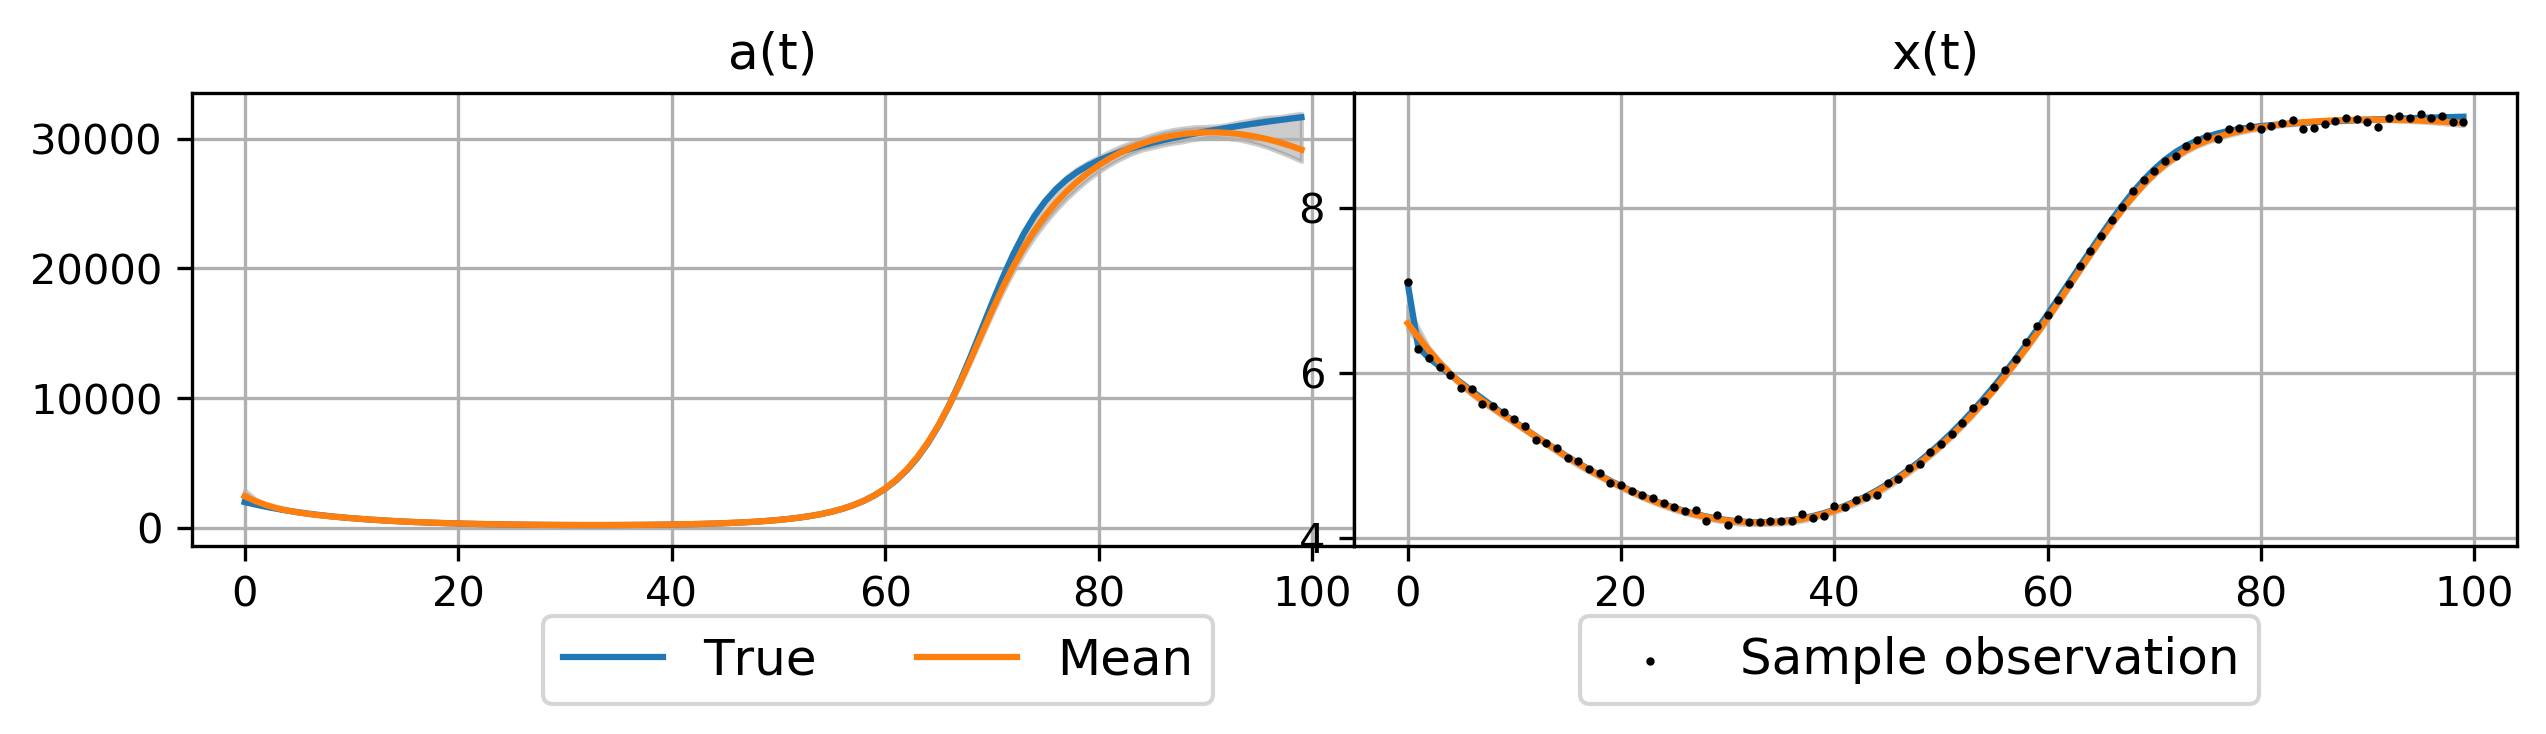

In [17]:
days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./obs_per_day)
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5

It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma) * np.exp(true_x))

for i in range(100):
    all_a[i] = all_a1[i] * 1e5 + all_a2[i] * 1e3 * Tt
    

%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1)
lower_95 = np.percentile(all_a, 97.5, axis=0)
upper_95 = np.percentile(all_a, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_a, label='True')
plt.plot(x, np.mean(all_a, axis=0), label='Mean')
plt.grid()
plt.title('a(t)')
plt.legend(bbox_to_anchor=(0.9, -0.1), fontsize=12, ncol=4)


ax1 = plt.subplot(1, 2, 2)
yobs = np.load('G:/HIV observations.npy')[1]
lower_95 = np.percentile(all_reconstructed_x, 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_x)
plt.plot(x, np.mean(all_reconstructed_x, axis=0))
plt.scatter(np.arange(0, days, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('x(t)')
plt.legend(bbox_to_anchor=(0.8, -0.1), fontsize=12, ncol=4)

# Calculate RMSE

In [18]:
a_RMSE = np.zeros(100)
x_RMSE = np.zeros(100)
for i in range(100):
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))
    a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - all_a[i])))

print(np.mean(a_RMSE), np.std(a_RMSE))    
print(np.mean(x_RMSE), np.std(x_RMSE))

555.4967510284378 178.60773970577682
0.06135282997558909 0.006643769281521622


# Hulin Wu

In [19]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt


days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./(obs_per_day * linspace))
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5


def true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda - true_rho * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], state_ls[:, 1], np.log(states[:, 2])


Tt, It, true_x = true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day)


It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma[::1000]) * np.exp(true_x))

def W(t, h, days=100):
    m = np.maximum(0, 0.75 * (1 - ((t - np.arange(0, days, 1)) / h) ** 2) / h)
    return np.diag(m)

def Xp(t, p, days=100):
    X = np.zeros((days, p + 1))
    for i in range(p + 1):
        X[:, i] = (np.arange(0, days, 1) - t) ** i
    return X

def beta_hat(t, yobs, p, h):
    return np.linalg.inv(Xp(t, p).T.dot(W(t, h)).dot(Xp(t, p))).dot(Xp(t, p).T).dot(W(t, h)).dot(yobs)
    
    
def Z(t, q): 
    global Tt
    Z = np.zeros((days, 2 * (q + 1)))
    for i in range(q + 1):
        Z[:, i] = (np.arange(1, days + 1, 1) - t) ** i
    for i in range(q+1, 2 * q + 2):
        Z[:, i] = Tt * (np.arange(1, days + 1, 1) - t) ** (i - q - 1)  
    return Z

def e(q):
    e = np.zeros((2, 2 * (q + 1)))
    e[0, 0] = 1
    e[1, q + 1] = 1
    return e


    
def a(t, yobs, q, h1, h2, p1 = 1, p2 = 2):
    U1 = np.zeros((days, p1 + 1))
    for i in range(days):
        U1[i] = beta_hat(i, yobs, p1, h1).reshape(1, -1)
    U2 = np.zeros((days, p2 + 1))
    for i in range(days):
        U2[i] = beta_hat(i, yobs, p2, h1).reshape(1, -1)
    return e(q).dot(np.linalg.inv(Z(t, q).T.dot(W(t, h=h2)).dot(Z(t, q)))).dot(Z(t, q).T).dot(W(t, h=h2)).dot(U2[:, 1] + 3.5 * U1[:, 0])

def recover_data(a, state0, linspace=100, days=100, obs_per_day=1):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    # Use Gaussian interpolation for theta    
    a_interp = np.interp(np.arange(0, 100, 1 / linspace), np.arange(0, 100, 1), a)
    for i in range(1, linspace * days):
        index = i - 1
        state_ls[i] = state_ls[i - 1] + step_size * (
                     a_interp[index] - 3.5 * state_ls[i - 1]) 

    return state_ls[::linspace]

data = np.load('G:/HIV observations.npy')
Tt = data[0][:, 1]
yobs = np.zeros((100, 100))
for i in range(100):
    yobs[i] = np.exp(data[i, :, 0]) 
    



p = 1
q = 1
h1 = 6
h2 = 18

all_a1 = np.zeros((100, 100))
all_a2 = np.zeros((100, 100))
all_a = np.zeros((100, 100))
for i in range(100):
    print(i)
    for t in range(100):
        tmp = a(t + 1, yobs[i], q, h1, h2)
        all_a1[i][t] = tmp[0]
        all_a2[i][t] = tmp[1]
    all_a[i] = all_a1[i] + all_a2[i] * Tt
all_reconstructed_x = np.zeros((100, 100))

x_RMSE = np.zeros(100)
for i in range(100):
    all_reconstructed_x[i] = np.log(recover_data(all_a[i], 1200.))  
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


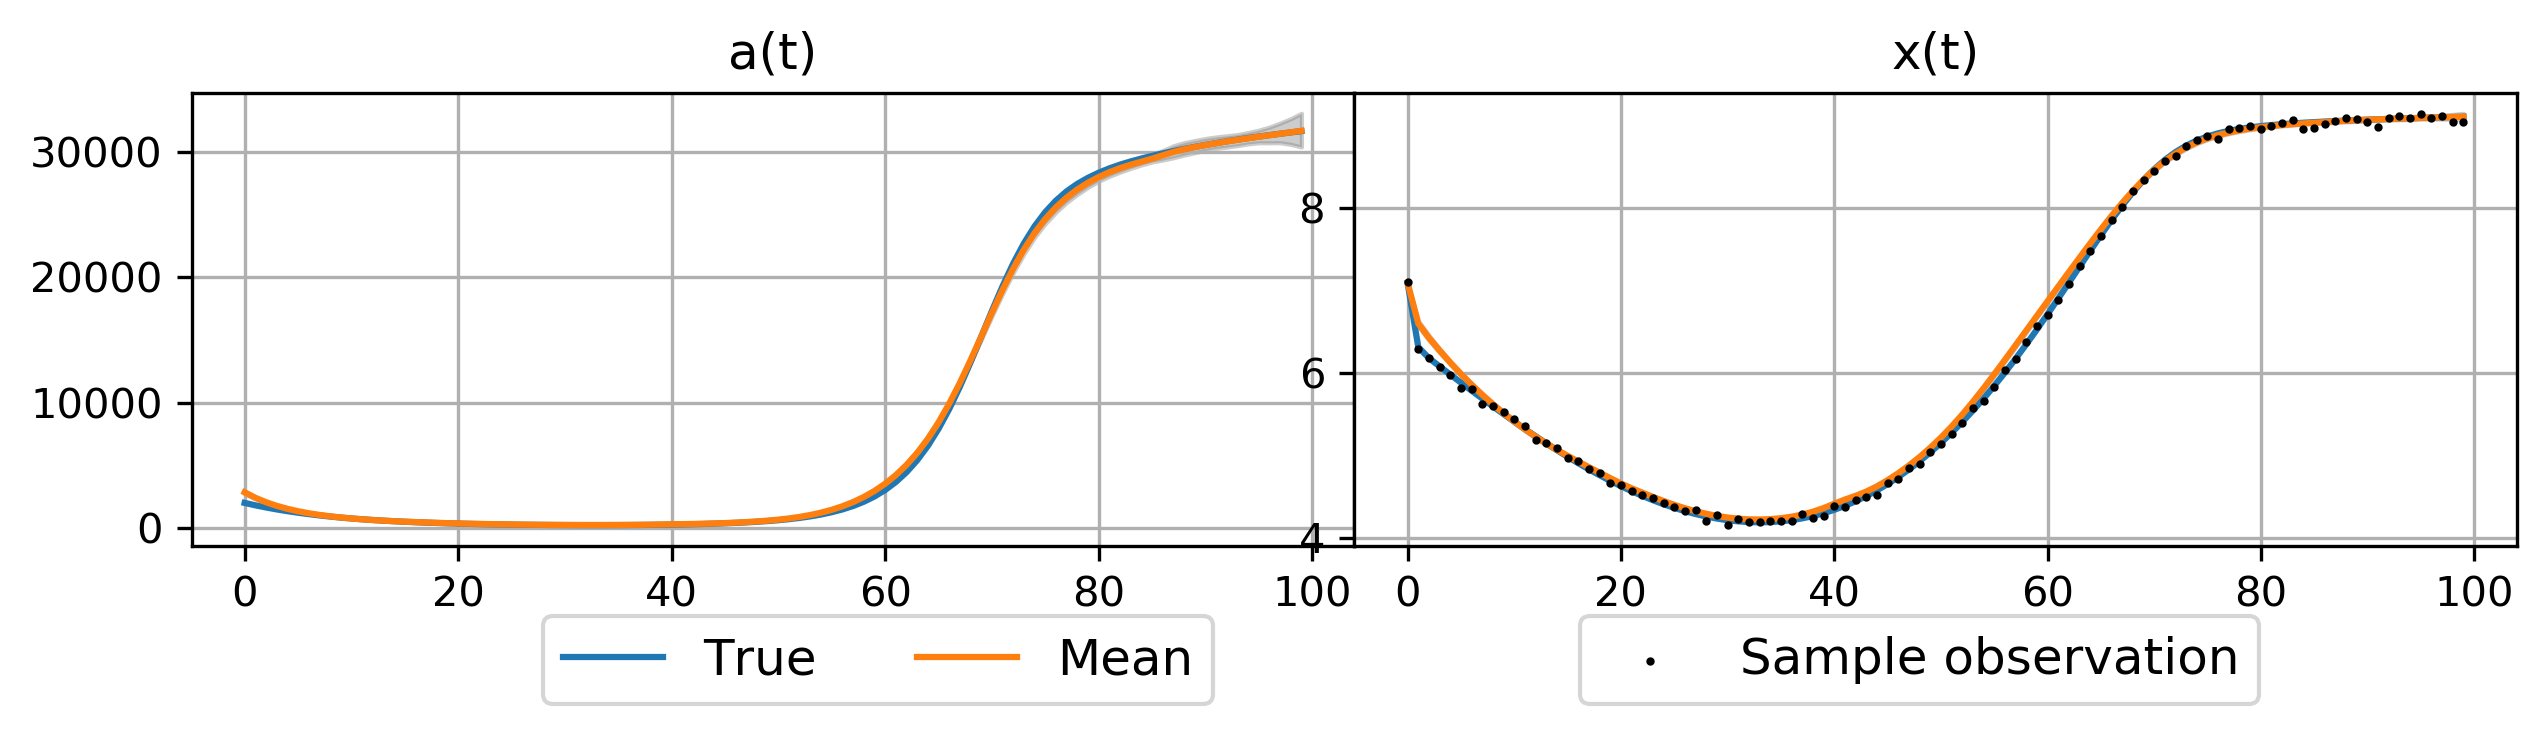

In [22]:
days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./obs_per_day)
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5

It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma) * np.exp(true_x))

for i in range(100):
    all_a[i] = all_a1[i] + all_a2[i]* Tt
    

%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1)
lower_95 = np.percentile(all_a, 97.5, axis=0)
upper_95 = np.percentile(all_a, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_a, label='True')
plt.plot(x, np.mean(all_a, axis=0), label='Mean')
plt.grid()
plt.title('a(t)')
plt.legend(bbox_to_anchor=(0.9, -0.1), fontsize=12, ncol=4)


ax1 = plt.subplot(1, 2, 2)
yobs = np.load('G:/HIV observations.npy')[1]
lower_95 = np.percentile(all_reconstructed_x, 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_x)
plt.plot(x, np.mean(all_reconstructed_x, axis=0))
plt.scatter(np.arange(0, days, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('x(t)')
plt.legend(bbox_to_anchor=(0.8, -0.1), fontsize=12, ncol=4)

In [23]:
# RMSE

In [24]:
a_RMSE = np.zeros(100)
x_RMSE = np.zeros(100)
for i in range(100):
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))
    a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - all_a[i])))

print(np.mean(a_RMSE), np.std(a_RMSE))    
print(np.mean(x_RMSE), np.std(x_RMSE))

291.51063521853285 48.417661365241884
0.07496513281573654 0.002964581520456526
